In [27]:
from langgraph.graph import START, END, StateGraph
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing import TypedDict, List, Dict, Literal
from pydantic import BaseModel
import operator
import json
import os
from dotenv import load_dotenv

from IPython.display import Image, display, Markdown


print(" All imports successful")


 All imports successful


In [29]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found in .env file!")

print(" API key loaded")

 API key loaded


In [30]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=openai_api_key
)

print(f" LLM initialized: {llm.model_name}")

 LLM initialized: gpt-4o-mini


In [31]:
class QualityScores(BaseModel):
    """Structured quality scores for a draft."""
    clarity: int  
    completeness: int  
    accuracy: int 
    
    def is_high_quality(self) -> bool:
        """Check if all scores are >= 4."""
        return all(score >= 4 for score in [self.clarity, self.completeness, self.accuracy])

In [32]:
class AdaptiveReflectionState(TypedDict):
    """Enhanced state with quality metrics."""
    task: str  
    draft: str  
    critique: str  
    scores: QualityScores  
    score_history: List[Dict[str, int]]  
    iterations: int 
    final_output: str  

In [33]:

MAX_REFLECTIONS = 3  

def generator(state: AdaptiveReflectionState) -> dict:
    """Generate or refine based on critique."""
    if state["iterations"] == 0:
       
        prompt = f"""Create a response for this task:

Task: {state['task']}

Provide a clear, complete answer."""
        print("\n GENERATING INITIAL DRAFT...")
    else:
        prompt = f"""Improve this draft based on the critique:

Task: {state['task']}

Current draft: {state['draft']}

Critique: {state['critique']}

Create an improved version that addresses the critique."""
        print(f"\n REFINING (Iteration {state['iterations']})...")
    
    response = llm.invoke([HumanMessage(content=prompt)])
    print(" Draft created")
    
    return {"draft": response.content}


In [34]:
def critic_with_scoring(state: AdaptiveReflectionState) -> dict:
    """Evaluate draft and provide structured critique with scores."""

    scoring_prompt = f"""Evaluate this response and provide numerical scores (1-5) for each quality dimension:

Task: {state['task']}

Response: {state['draft']}

Score based on:
1. CLARITY (1-5): Is the response clear and easy to understand?
2. COMPLETENESS (1-5): Does it fully address the task?
3. ACCURACY (1-5): Is the information correct and factual?

Return ONLY valid JSON in this format:
{{
    "clarity": <score>,
    "completeness": <score>, 
    "accuracy": <score>
}}"""

    print("\n EVALUATING DRAFT QUALITY...")
    scoring_response = llm.invoke([HumanMessage(content=scoring_prompt)])
    
    try:
        
        scores_dict = json.loads(scoring_response.content)
        scores = QualityScores(**scores_dict)
    except json.JSONDecodeError:
    
        print(" Could not parse scores from response, using default scores")
        print(f"Raw response: {scoring_response.content}")
        scores = QualityScores(clarity=3, completeness=3, accuracy=3)
    except Exception as e:
        print(f" Error parsing scores: {e}")
        scores = QualityScores(clarity=3, completeness=3, accuracy=3)
    
   
    critique_prompt = f"""Provide constructive critique for this response:

Task: {state['task']}
Response: {state['draft']}

Current scores: Clarity={scores.clarity}, Completeness={scores.completeness}, Accuracy={scores.accuracy}

Provide specific feedback on what to improve. Focus on the lowest scoring areas first.
Be concrete and actionable in your suggestions."""

    critique_response = llm.invoke([HumanMessage(content=critique_prompt)])
    
    print(f"\n QUALITY SCORES (Iteration {state['iterations']}):")
    print(f"   Clarity: {scores.clarity}/5")
    print(f"   Completeness: {scores.completeness}/5") 
    print(f"   Accuracy: {scores.accuracy}/5")
    print(f"   High Quality? {' YES' if scores.is_high_quality() else '❌ NO (needs refinement)'}")
    
  
    score_record = {
        "iteration": state["iterations"],
        "clarity": scores.clarity,
        "completeness": scores.completeness,
        "accuracy": scores.accuracy,
        "total": scores.clarity + scores.completeness + scores.accuracy
    }
    
   
    score_history = state.get("score_history", [])
    score_history.append(score_record)
    
    return {
        "critique": critique_response.content,
        "scores": scores,
        "score_history": score_history,
        "iterations": state["iterations"] + 1
    }

In [35]:
def finalizer(state: AdaptiveReflectionState) -> dict:
    """Set final output and show improvement summary."""
    print("\n" + "="*60)
    print(" REFLECTION COMPLETE!")
    print("="*60)
    

    print("\n QUALITY IMPROVEMENT SUMMARY:")
    print("-" * 40)
    for record in state["score_history"]:
        print(f"Iteration {record['iteration']}: "
              f"Clarity={record['clarity']}, "
              f"Completeness={record['completeness']}, "
              f"Accuracy={record['accuracy']} "
              f"(Total: {record['total']}/15)")
    
    final_scores = state["scores"]
    print("\n FINAL SCORES:")
    print(f"  Clarity: {final_scores.clarity}/5")
    print(f"  Completeness: {final_scores.completeness}/5")
    print(f"  Accuracy: {final_scores.accuracy}/5")
    print(f"  Overall: {final_scores.clarity + final_scores.completeness + final_scores.accuracy}/15")
    
    if final_scores.is_high_quality():
        print("\n RESULT: All scores ≥4 - High quality achieved!")
    else:
        print(f"\n RESULT: Some scores <4 - Max iterations ({MAX_REFLECTIONS}) reached")
    
    print("="*60)
    
    return {"final_output": state["draft"]}

In [36]:
def should_refine_based_on_scores(state: AdaptiveReflectionState) -> Literal["generator", "finalizer"]:
    """Decide if we need more refinement based on scores."""
   
    if state["iterations"] >= MAX_REFLECTIONS:
        print(f"\n Max iterations ({MAX_REFLECTIONS}) reached")
        return "finalizer"
    
    if state["scores"].is_high_quality():
        print(f"\n All scores ≥4 - Quality threshold met!")
        return "finalizer"
    
    print(f"\n Needs refinement - scores below threshold")
    return "generator"


In [37]:
print("Building Adaptive Reflection Agent...")

reflection_builder = StateGraph(AdaptiveReflectionState)

reflection_builder.add_node("generator", generator)
reflection_builder.add_node("critic", critic_with_scoring)
reflection_builder.add_node("finalizer", finalizer)

reflection_builder.add_edge(START, "generator")
reflection_builder.add_edge("generator", "critic")
reflection_builder.add_conditional_edges(
    "critic",
    should_refine_based_on_scores,
    {"generator": "generator", "finalizer": "finalizer"}
)
reflection_builder.add_edge("finalizer", END)

adaptive_reflection_agent = reflection_builder.compile()

print(" Adaptive Reflection Agent created!")


Building Adaptive Reflection Agent...
 Adaptive Reflection Agent created!


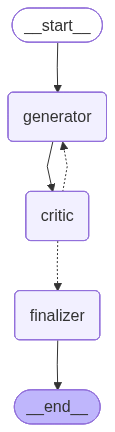

In [38]:

graph_image = adaptive_reflection_agent.get_graph().draw_mermaid_png()
 
display(Image(graph_image))
    
  

In [39]:
print("\n" + "="*70)
print(" TEST 1: Task requiring refinement")
print("="*70)

test_task = "Explain quantum computing in simple terms for beginners"

result = adaptive_reflection_agent.invoke({
    "task": test_task,
    "draft": "",
    "critique": "",
    "scores": QualityScores(clarity=3, completeness=3, accuracy=3),
    "score_history": [],
    "iterations": 0,
    "final_output": ""
})

print("\n FINAL OUTPUT:")
print("="*40)
print(result["final_output"])



 TEST 1: Task requiring refinement

 GENERATING INITIAL DRAFT...
 Draft created

 EVALUATING DRAFT QUALITY...

 QUALITY SCORES (Iteration 0):
   Clarity: 5/5
   Completeness: 5/5
   Accuracy: 5/5
   High Quality?  YES

 All scores ≥4 - Quality threshold met!

 REFLECTION COMPLETE!

 QUALITY IMPROVEMENT SUMMARY:
----------------------------------------
Iteration 0: Clarity=5, Completeness=5, Accuracy=5 (Total: 15/15)

 FINAL SCORES:
  Clarity: 5/5
  Completeness: 5/5
  Accuracy: 5/5
  Overall: 15/15

 RESULT: All scores ≥4 - High quality achieved!

 FINAL OUTPUT:
Sure! Let’s break down quantum computing in simple terms.

**What is Quantum Computing?**

At its core, quantum computing is a new type of computing that uses the principles of quantum mechanics, which is the science that explains how very small particles, like atoms and photons, behave. Traditional computers, like the one you might be using right now, process information using bits. A bit can be either a 0 or a 1, which is li

In [ ]:
def print_reflection_summary(result):
    """Print a summary of the reflection process."""
    print("\n REFLECTION PROCESS SUMMARY:")
    print("="*60)
    
    if "score_history" in result:
        print("\n Score Progression:")
        for i, record in enumerate(result["score_history"]):
            print(f"  Iteration {i}: "
                  f"C={record['clarity']}, "
                  f"P={record['completeness']}, "
                  f"A={record['accuracy']} "
                  f"(Total: {record['total']}/15)")
    
    if "iterations" in result:
        print(f"\n Total iterations: {result['iterations']}")
    
    print(f"\n Final draft length: {len(result.get('final_output', ''))} characters")
    print("="*60)


print_reflection_summary(result)


 REFLECTION PROCESS SUMMARY:

 Score Progression:
  Iteration 0: C=5, P=5, A=5 (Total: 15/15)

 Total iterations: 1

 Final draft length: 2108 characters
